# testing_power_normalizations
This notebook is a testing ground for creating and normalizing power spectra, and cross-checking between different methods (i.e., light curve in units of counts/bin vs light curve in units of counts/second). Trying things out for stingray/tests/test_crossspectrum.py.

In [1]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

### Setting things up
Using the same seed as in stingray/tests/test_crossspectrum.py (henceforth "the stingray test") and the same function for `counts1`. Decreased `dt`, so decreased `n_bins`, from what's in the stingray test so that it plots easier below. 

In [2]:
np.random.seed(20160528)
tstart = 0.0
tend = 1.0
dt = 0.001
n_bins = int(tend/dt)
time = np.arange(tstart + 0.5 * dt, tend + 0.5 * dt, dt)
assert n_bins == int(time.shape[0])
counts1 = np.random.poisson(0.01, size=time.shape[0])  # exact same function as in test_crossspectrum.py in stingray
lc_1 = counts1/dt  # puts it in units of counts/second
idx_nyq = int(n_bins/2)+1  # index of the nyquist frequency
freqs = np.abs(fftpack.fftfreq(n_bins, d=dt)[0:idx_nyq])  # nyquist freq is neg in scipy; want it to be positive for plotting purposes
mean_1 = np.mean(lc_1)  # actual mean of the light curve
realrate_1 = 10.  # expected mean of the light curve
print(mean_1, realrate_1)

11.0 10.0


### Computing the power of the counts/second light curve 

In [3]:
lc_sub_mean_1 = lc_1 - mean_1  # removes the DC component at f = 0 Hz
fft_1 = fftpack.fft(lc_sub_mean_1)
powersquare1 = np.square(fft_1)[0:idx_nyq]  
print("Square:", powersquare1[1:5]) # why is this a complex number?1?!
poweramp1 = np.absolute(fft_1**2)[0:idx_nyq] # amplitude or magnitude (which is a real number)
powerreal1 = np.real(fft_1**2)[0:idx_nyq]  # real component of the power
powerconj1 = np.multiply(fft_1, np.conj(fft_1))[0:idx_nyq]
print("Amp:", poweramp1[1:5])
print("Real:", powerreal1[1:5])
print("Conj mult:", powerconj1[1:5])  # I thought this was equal to just 'square' in the case of a power spectrum, but apparently it isn't
print(np.allclose(poweramp1, powerreal1))
print(np.allclose(poweramp1, powerconj1))

Square: [ 3036300.51606317+2311817.40138403j -3196179.70040037+3352375.1786515j
  3728835.36352467 +238968.32233154j -2032446.59593294+3591338.92958069j]
Amp: [ 3816231.19336178  4631844.55867099  3736484.84907274  4126566.91117945]
Real: [ 3036300.51606317 -3196179.70040037  3728835.36352467 -2032446.59593294]
Conj mult: [ 3816231.19336178+0.j  4631844.55867099+0.j  3736484.84907274+0.j
  4126566.91117945+0.j]
False
True


## WEIRD.
Computing the power spectrum four different ways: squaring the fft, taking the real of the squared fft, taking the amplitude (or magnitude) of the squared fft, and multiplying fft by its complext conjugate. `powerconj1` is the 'true' way to do it, but I expected all four ways to give the same result. `powerconj1==poweramp1` and `powersquare1==powerreal1`, and `powersquare1` and `powerreal1` are giving the wrong answer. We can test this by normalizing them and seeing if they produce approximately the expected Poisson noise level.

In [4]:
abs_noise1 = 2. * realrate_1

print("From the amplitude of the fft^2:")
absamp1 = poweramp1 * 2.0 * dt / float(n_bins)
print(np.mean(absamp1), abs_noise1)
print(np.isclose(np.mean(absamp1), abs_noise1, atol=3))

print("From the real component of the fft^2:")
absreal1 = powerreal1 * 2.0 * dt / float(n_bins)
print(np.mean(absreal1), abs_noise1)
print(np.isclose(np.mean(absreal1), abs_noise1, atol=3))

From the amplitude of the fft^2:
21.7165668663 20.0
True
From the real component of the fft^2:
-0.239520958084 20.0
False


We see that the amp one is right, and the real one is wrong. But why are they different?? And, stingray uses 'conj' in crossspectrum.py, but the answers in the stingray test suite look like that of 'real'. Why???

Plotting, in case visual helps. Red line is the expected poisson noise level, blue is normalized from 'amp' power spectrum, orange is normalized from 'real' power spectrum.

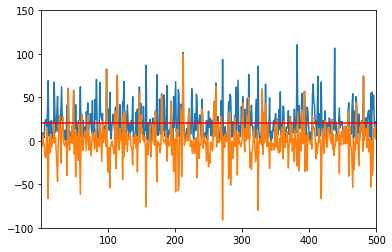

In [5]:
plt.plot(freqs, absamp1)
plt.plot(freqs, absreal1)
plt.axhline(y=abs_noise1, xmin=freqs[0], xmax=freqs[-1], color='r')
plt.xlim(freqs[1], freqs[-1])
plt.ylim(-100, 150)
plt.show()
plt.close()

Now computing the power spectrum of the light curve in units of counts/bin. This has a different absolute rms-squared normalization for the power spectrum, since the input light curve is in different units. This was my initial reason for making this testing notebook. Comparing with the same expected Poisson noise level, because we're using the same normalization, just getting there a different way. We see that the 'amp' and 'real' still don't agree, and 'amp' and 'conj' do agree.

In [6]:
ctsfft_1 = fftpack.fft(counts1, axis=0)
ctspowamp1 = np.absolute(ctsfft_1**2)[0:idx_nyq]
ctspowreal1 = np.real(ctsfft_1**2)[0:idx_nyq]
ctspowconj1 = np.multiply(ctsfft_1, np.conj(ctsfft_1))[0:idx_nyq]
print(np.allclose(ctspowamp1, ctspowreal1))
print(np.allclose(ctspowamp1, ctspowconj1))

phots_1 = np.sum(counts1)
cts_absamp1 = ctspowamp1 * 2. * mean_1 / phots_1
cts_absreal1 = ctspowreal1 * 2. * mean_1 / phots_1

print("From the amplitude of the fft^2:")
print(np.mean(cts_absamp1), abs_noise1)
print(np.isclose(np.mean(cts_absamp1), abs_noise1, atol=3))
print("From the real component of the fft^2:")
print(np.mean(cts_absreal1), abs_noise1)
print(np.isclose(np.mean(cts_absreal1), abs_noise1, atol=3))

False
True
From the amplitude of the fft^2:
22.1996007984 20.0
True
From the real component of the fft^2:
0.243512974052 20.0
False


Plotting again. Can see that the power computed with 'amp' gives the expected Poisson noise level, whereas the power computed with 'real' doesn't.

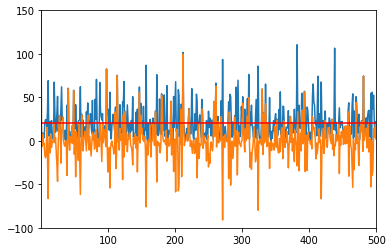

In [7]:
plt.plot(freqs, cts_absamp1)
plt.plot(freqs, cts_absreal1)
plt.axhline(y=abs_noise1, xmin=freqs[0], xmax=freqs[-1], color='r')
plt.xlim(freqs[1], freqs[-1])
plt.ylim(-100, 150)
plt.show()
plt.close()

Its value looks more like that of fractional rms-squared normalized power. Speaking of, let's check with other normalizations for 'amp' and 'real'. Using the counts/sec light curve.

In [8]:
frac_noise1 = 2.0 / realrate_1

print("From the amplitude of the fft^2:")
fracamp1 = poweramp1 * 2.0 * dt / float(n_bins) / (mean_1**2)
print(np.mean(fracamp1), frac_noise1)
print(np.isclose(np.mean(fracamp1), frac_noise1, atol=0.025))

print("From the real component of the fft^2:")
fracreal1 = powerreal1 * 2.0 * dt / float(n_bins) / (mean_1**2)
print(np.mean(fracreal1), frac_noise1)
print(np.isclose(np.mean(fracreal1), frac_noise1, atol=0.025))

From the amplitude of the fft^2:
0.179475759225 0.2
True
From the real component of the fft^2:
-0.00197951205028 0.2
False


In [9]:
leahy_noise = 2.
print("From the amplitude of the fft^2:")
leahyamp1 = poweramp1 * 2.0 * dt / float(n_bins) / mean_1
print(np.mean(leahyamp1), leahy_noise)
print(np.isclose(np.mean(leahyamp1), leahy_noise, atol=0.05))
print("From the real component of the fft^2:")
leahyreal1 = powerreal1 * 2.0 * dt / float(n_bins) / mean_1
print(np.mean(leahyreal1), leahy_noise)
print(np.isclose(np.mean(leahyreal1), leahy_noise, atol=0.05))

From the amplitude of the fft^2:
1.97423335148 2.0
True
From the real component of the fft^2:
-0.0217746325531 2.0
False


So 'real' doesn't work for any of them. Still don't understand why they're different.

I think this explains why the order of magnitude for the Poisson noise level in the stingray test was so low, but it doesn't explain why it passes the leahy and frac tests that also get executed!

Below is for writing a test for lc_2 and normalizing the cross spectrum between the two of them, but we need to get the power spectrum of lc_1 working first.

In [10]:
# np.random.seed(20160528)  # same seed as before
# counts2 = np.random.negative_binomial(1, 0.09, size=time.shape[0])  # copied same function as in stingryay/tests/test_crossspectrum.py
# lc_2 = counts2/dt
# mean_2 = np.mean(lc_2)
# realrate_2 = 1.0e5
# print(mean_2, realrate_2)
# fft_2 = fftpack.fft(lc_2-mean_2, axis=0)
# cross = fft_1 * np.conj(fft_2)
# cross = cross[0:len_pos]
# power_2 = np.absolute(fft_2)**2

In [11]:
# abs_2 = power_2 * 2.0 * dt / float(time.shape[0])
# abs_noise2 = 2. * real_2
# print(np.mean(abs_2), abs_noise2)
# frac_2 = power_2 * 2.0 * dt / float(time.shape[0]) / (mean_2**2)
# frac_noise2 = 2.0 / real_2
# print(np.mean(frac_2), frac_noise2)

In [12]:
# leahy_2 = power_2 * 2.0 * dt / float(time.shape[0]) / mean_2
# leahy_noise = 2.
# print(np.mean(leahy_2), leahy_noise)

In [13]:
# abs_cross = cross * 2.0 * dt / float(time.shape[0])
# abs_noisec = 2. * np.sqrt(mean_1*mean_2)
# print(np.mean(abs_cross), abs_noisec)
# frac_cross = cross * 2.0 * dt / float(time.shape[0]) / (mean_1*mean_2)
# frac_noisec = 2.0 / np.sqrt(mean_1*mean_2)
# print(np.mean(frac_cross), frac_noisec)